In [30]:
# Import the Required Python Libraries

import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime

In [31]:
#This part of the code reads the data from file.gst

gst_file = None
##Lets find the gst file name that is not named clean_file.gst
for filename in os.listdir('.'):
    if filename.endswith('.gst') and filename != 'clean_file.gst':
        gst_file = filename
        break

if gst_file: # read the contents into a list
    with open(gst_file, 'r') as f:
        lines = f.readlines()
else:
    # Lets add to convergence.log
    print (f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] No suitable .gst file found yet....", flush=True)
    sys.exit(0) # Perhaps the solver has not started, lets exit with code 0

In [32]:
#This part of the code creates a dataframe saved with the info from file.gst

# Lets update the data diregarding instances of '<'
cleaned_lines = [line for line in lines if not line.strip().startswith('<')]

# Lets open a new file named clean_file.gst for writing the updated data without Headers
with open('clean_file.gst', 'w') as f:
    f.writelines(cleaned_lines)

# Lets define the column names based on the ansys file.gst info
col_names = ['Time', 'Load Step', 'Sub-step', 'Cum Iter', 'Time Incr', 'Max DOF Incr', 'Line Search Parameter', 'Bisection',
             'F CRIT', 'F L2', 'U CRIT', 'U INF', 'M CRIT', 'M L2', 'Remesh',
             'Max Resi F', 'Node with Max DOF Incr', 'DOF with Max DOF Incr', 'Node with Max Resi F', 'DOF with Max Resi F']

# Lets Define the Data types
# Note I am only defining the data types of use, this can be expanded as needed for other plots
data_types = {'Time': float, 'Cum Iter': float, 'F CRIT': float, 'F L2': float}

# Lets createa dataframe and store the cleaned data
data = pd.read_csv('clean_file.gst', delim_whitespace=True, header=None, names=col_names, dtype=data_types)

# Store data indices where Substep Convergence is increased by 1
substep_convergence_indices = data[data['Sub-step'].diff() == 1].index

# Store data indices where Load Step Convergence is increased by 1
loadstep_convergence_indices = data[data['Load Step'].diff() == 1].index

# Store data indices where Bisection is not 0
bisection_indices = data[data['Bisection'] != 0].index


[2023-08-15 23:58:32] Creating Force Convergence Plot


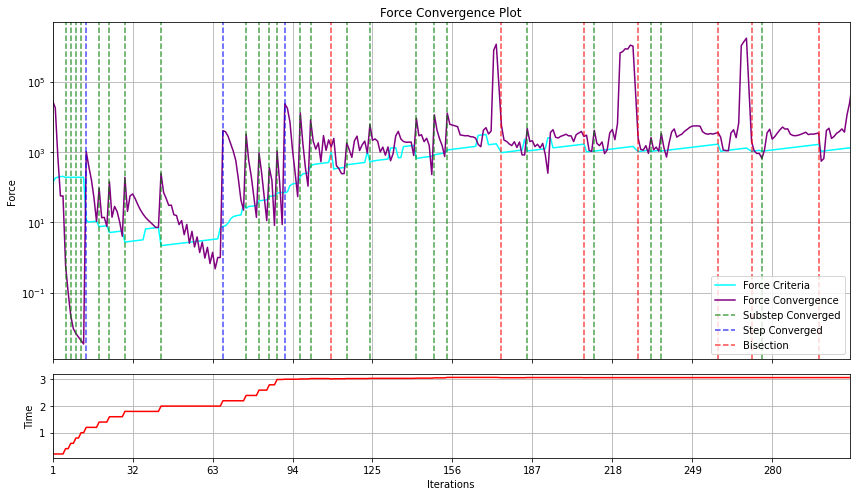

In [33]:
# This part of the code uses matplotlib to generate the convergence plot

# Log and Create a timestamp in convergence.log file
print (f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Creating Force Convergence Plot", flush=True)

# Lets create the subplots. 
# Note here 12 is width and 7 is heights in inches, adjust as required
# Bottom plot takes up 1/5th, adjust as required
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [4, 1]})

# Lets plot the Upper Plot: Force Convergence
ax[0].plot(data['Cum Iter'], data['F CRIT'], label='Force Criteria', color='cyan')
ax[0].plot(data['Cum Iter'], data['F L2'], label='Force Convergence', color='purple')
ax[0].set_ylabel('Force')
ax[0].set_yscale('log')
ax[0].set_title('Force Convergence Plot')
#Lets add in the vertical lines for loadstep, substep convergence and bisections
# Adjust alhpa for transperancy
for index in substep_convergence_indices:
    ax[0].axvline(x=data['Cum Iter'][index], color='green', linestyle='--', alpha=0.7)
for index in loadstep_convergence_indices:
    ax[0].axvline(x=data['Cum Iter'][index], color='blue', linestyle='--', alpha=0.7)
for index in bisection_indices:
    ax[0].axvline(x=data['Cum Iter'][index], color='red', linestyle='--', alpha=0.7)

# Legend for vertical lines corresponding to Substep, Step Convergence or Bisection
# Workaround by plotting vertical lines on x=-1,then forcing the plot to begin at x=1
# Adjust alhpa for transperancy
ax[0].axvline(x=-1, color='green', linestyle='--', alpha=0.7, label='Substep Converged')
ax[0].axvline(x=-1, color='blue', linestyle='--', alpha=0.7, label='Step Converged')
ax[0].axvline(x=-1, color='red', linestyle='--', alpha=0.7, label='Bisection')
ax[0].legend()
ax[0].grid(True)

# Lets plot the Bottom Plot: Time vs Iterations
ax[1].plot(data['Cum Iter'], data['Time'], label='Bisection', color='red')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Time')
ax[1].grid(True)

# Lets calculate and setup a suitable interval for the x-axis
num_ticks = 10  # Adjust the number of ticks to display on the x-axis
num_points = len(data['Cum Iter']) # Consider the total number of iterations
interval = max(1, num_points // num_ticks)  # Calculate the suitable interval

# Set x-axis ticks and labels
x_ticks = range(1, num_points + 1, interval)
x_labels = range(1, num_points + 1, interval)
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)

# Lets adjust the x-axis limits to start from 1 and end at total iteration
plt.xlim(1, num_points)

# Lets prevent any overlapping
plt.tight_layout()

# Finally lets Save the plot as a PNG file, can change to JPEG if needed
plt.savefig('convergence.png', dpi=300)